In [1]:
import rospy
from sensor_msgs.msg import Image
from geometry_msgs.msg import Twist

In [2]:
rospy.init_node('watcher')
def snap():
    return rospy.wait_for_message('/camera/rgb/image_raw', Image, timeout=1.)
cmd_vel_pub = rospy.Publisher('cmd_vel', Twist, queue_size=1)

In [3]:
import cv2, numpy as np
from cv_bridge import CvBridge
from matplotlib import pyplot as plt

(480, 640, 3)


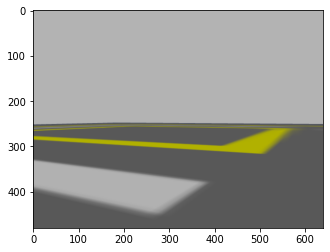

In [4]:
bridge = CvBridge()
def image():
    msg = snap()
    return bridge.imgmsg_to_cv2(msg,desired_encoding='bgr8')
def show(img, **kwargs):
    plt.imshow(img[...,::-1], **kwargs)

In [6]:
import scipy.stats
def pval(dist, points):
    "Returns the p-value of points on a symmetric distribution."
    cumul = dist.cdf(points)
    return 2*np.minimum(cumul, 1-cumul)

def pval_lower(dist, points):
    "Returns the lower p-value of points on a distribution."
    return dist.cdf(points)

def pval_upper(dist, points):
    "Returns the upper p-value of points on a distribution."
    return dist.sf(points)

In [7]:
hue_dist_yellow = scipy.stats.norm(29, 5)
sat_dist_yellow = scipy.stats.expon(0, 5)
val_dist_yellow = scipy.stats.expon(78, 5)
inv_tf = lambda x: 255 - x

In [8]:
hue_dist_white = scipy.stats.norm(0, np.inf)
sat_dist_white = scipy.stats.expon(0, 5)
val_dist_white = scipy.stats.expon(78, 5)
inv_tf = lambda x: 255 - x

In [9]:
def filter_yellow(hsv):
    hue, sat, val = np.moveaxis(hsv.astype(float), -1, 0)
    pval_hue = pval(hue_dist_yellow, hue)
    pval_sat = pval_upper(sat_dist_yellow, inv_tf(sat))
    pval_val = pval_upper(val_dist_yellow, inv_tf(val))
    return pval_hue * pval_sat * pval_val

def filter_white(hsv):
    hue, sat, val = np.moveaxis(hsv.astype(float), -1, 0)
    pval_hue = pval(hue_dist_white, hue)
    pval_sat = pval_upper(sat_dist_white, sat)
    pval_val = pval_upper(val_dist_white, inv_tf(val))
    return pval_hue * pval_sat * pval_val

In [10]:
def angle_dist(a, b):
    "Calculates the acute distance between two angles in degrees."
    dist = (a - b) % (2*np.pi)
    return np.where(dist <= np.pi, dist, 2*np.pi - dist)

def angle_diff(a, b):
    "Calculates the acute difference between two angles in degrees."
    dist = (a - b) % (2*np.pi)
    return np.where(dist <= np.pi, dist, dist - 2*np.pi)

def recenter(angles, mid_angle):
    return np.mod(angles - mid_angle + np.pi, 2*np.pi) + mid_angle - np.pi
    
WIDTH = 640
HEIGHT = 480
def idx_to_xy(idx):
    return idx[...,::-1] * (1,-1) + (0, HEIGHT)
def xy_to_idx(xy):
    return ((xy - (0, HEIGHT)) * (1,-1))[...,::-1]

In [11]:
def search_by_angle(diff, angle):
    angles = np.arctan2(diff[:,1],diff[:,0])
    return np.argmin(angle_dist(angles, angle))

def cart_to_rad(coords):
    dist = np.linalg.norm(coords, axis=-1)
    angles = np.arctan2(coords[...,1],coords[...,0])
    return np.stack([dist, angles], axis=-1)

Y_VANISHING_NEAR = 105
Y_VANISHING_FAR = 225
CENTER = WIDTH / 2

def dist_tf(dist, y):
    coeff = ((y - Y_VANISHING_FAR) / (Y_VANISHING_NEAR - Y_VANISHING_FAR))
    return np.where(y < Y_VANISHING_FAR, np.inf, dist * coeff)

def perspective_tf(xy):
    x, y = xy[...,0], xy[...,1]
    coeff = (y + Y_VANISHING_NEAR) / (Y_VANISHING_FAR + Y_VANISHING_NEAR)
    x_tf = np.where(y > Y_VANISHING_FAR, np.nan, CENTER + (x - CENTER) * coeff)
    y_tf = np.where(y > Y_VANISHING_FAR, np.inf, y * coeff**2 * (HEIGHT / Y_VANISHING_FAR))
    return np.stack([x_tf, y_tf], axis=-1)

In [79]:
def to_cv(idx):
    return np.round(idx[...,::-1]).astype(int).clip(-9999, 9999)

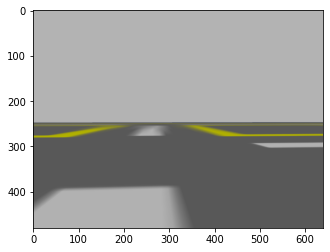

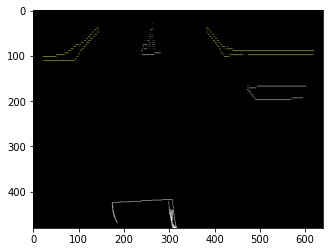

In [133]:
img = image()
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
filter_yellow_img = (filter_yellow(hsv) * 255).astype(np.uint8)
filter_white_img = (filter_white(hsv) * 255).astype(np.uint8)
filter_white_img[:260,:] = 0 # Erase sky
edges_yellow = cv2.Canny(filter_yellow_img, 20, 240)
edges_white = cv2.Canny(filter_white_img, 20, 240)

right_edges_idx = np.moveaxis(np.indices(edges_white.shape),0,-1)[edges_white>127].reshape(-1,2)
right_edges_xy = perspective_tf(idx_to_xy(right_edges_idx))

left_edges_idx = np.moveaxis(np.indices(edges_yellow.shape),0,-1)[edges_yellow>127].reshape(-1,2)
left_edges_xy = perspective_tf(idx_to_xy(left_edges_idx))

# Draw top-down perspective
img_overhead = np.zeros_like(img)
img_overhead[tuple(xy_to_idx(left_edges_xy).astype(int).clip((0,0),(HEIGHT-1,WIDTH-1)).T)] = (0, 255, 255)
img_overhead[tuple(xy_to_idx(right_edges_xy).astype(int).clip((0,0),(HEIGHT-1,WIDTH-1)).T)] = (255, 255, 255)

show(img)
plt.show()
show(img_overhead)

9 lines found!


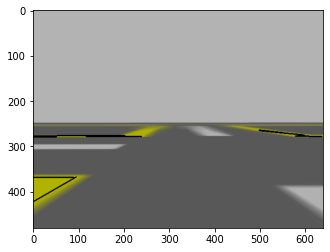

In [69]:
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
lines = cv2.HoughLinesP(edges_yellow, 1, np.pi/180, 40, minLineLength=40, maxLineGap=10)
if lines is None:
    lines = []
print(f"{len(lines)} lines found!")
img_w_lines = img.copy()
for x1,y1,x2,y2 in lines[:,0]:
    cv2.line(img_w_lines,(x1,y1),(x2,y2),(0,0,0),2)
show(img_w_lines)

In [40]:
from scipy.spatial.transform import Rotation

project_hom = np.array(
    [[1,0,0],
     [0,1,0],
     [0,0,0],
     [0,0,1]])
def homogeneous_cam2gnd(R_euler, T_vec, K_inv):
    rotation = Rotation.from_euler('xyz', R_euler)
    R = rotation.as_matrix()
    R_inv = R.T
    T_vec_inv = -R_inv @ T_vec
    M_inv = np.concatenate([R_inv, T_vec_inv[:,None]], axis=-1)
    H_inv = M_inv @ project_hom @ K_inv
    return H_inv

def homogeneous_translation(t_vec):
    T = np.eye(len(t_vec)+1)
    T[:len(t_vec),-1] = t_vec
    return T

In [43]:
from sensor_msgs.msg import CameraInfo
def camera_info():
    return rospy.wait_for_message('/camera/rgb/camera_info', CameraInfo, timeout=1.)
info = camera_info()
K = np.array(info.K).reshape(3,3)
K_inv = np.linalg.inv(K)

In [227]:
HEIGHT_CAMERA = 0.1
RESOLUTION_X = 20
RESOLUTION_Y = 80

R = [np.pi/2-0.1,0,0]
T = [0,0,HEIGHT_CAMERA]
H = homogeneous_cam2gnd(R, T, K_inv)

scale_matrix = np.eye(3) * (RESOLUTION_X, RESOLUTION_Y, 1)
H_scaled = scale_matrix @ H

def project_ground(img, out_size):
    # Apply bounding box but retain center
    T_center = homogeneous_translation(np.array([out_size[0]/2,0]))
    H_scaled_centered = T_center @ H_scaled

    # Apply transformation
    img_ground = cv2.warpPerspective(img, H_scaled_centered, out_size)
    return img_ground[::-1,::-1]

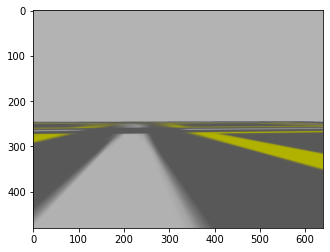

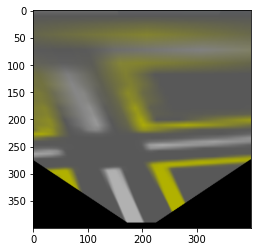

In [237]:
img = image()
img_projected = project_ground(img, (400,400))
show(img)
plt.show()
show(img_projected)

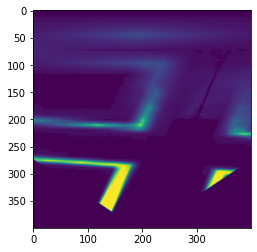

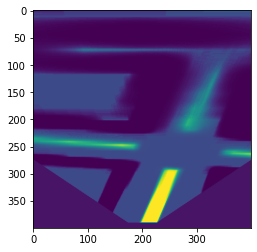

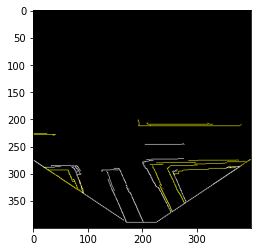

In [281]:
hsv = cv2.cvtColor(img_projected, cv2.COLOR_BGR2HSV)
filter_yellow_img = (filter_yellow(hsv) * 255).astype(np.uint8)
filter_white_img = (filter_white(hsv) * 255).astype(np.uint8)

edges_yellow = cv2.Canny(filter_yellow_img, 20, 240)
edges_white = cv2.Canny(filter_white_img, 20, 240)

edges = edges_yellow[...,None] * (0,1,1) + edges_white[...,None] * (1,1,1)

show(filter_yellow_img)
plt.show()
show(filter_white_img)
plt.show()
show(edges)

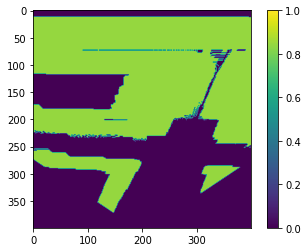

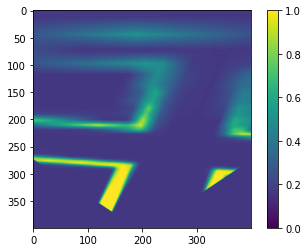

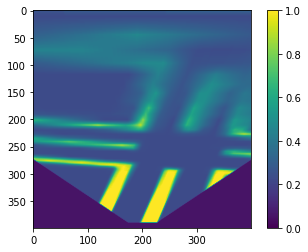

In [258]:
hue,sat,val = np.moveaxis(hsv, -1, 0)

hue_dist_yellow = scipy.stats.norm(29, 5)
sat_dist_yellow = scipy.stats.expon(0, 140)
val_dist_yellow = scipy.stats.expon(78, 60)
inv_tf = lambda x: 255 - x

pval_hue = pval(hue_dist_yellow, hue.astype(float))
show(pval_hue, vmin=0, vmax=1)
plt.colorbar()
plt.show()

pval_sat = pval_upper(sat_dist_yellow, inv_tf(sat).astype(float))
show(pval_sat, vmin=0, vmax=1)
plt.colorbar()
plt.show()

pval_val = pval_upper(val_dist_yellow, inv_tf(val).astype(float))
show(pval_val, vmin=0, vmax=1)
plt.colorbar()
plt.show()

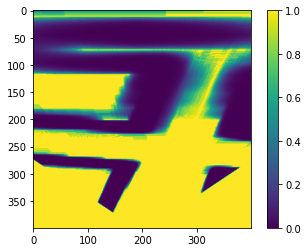

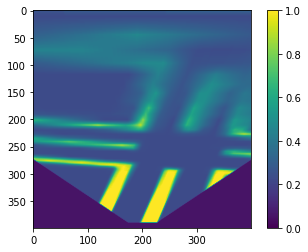

In [265]:
hue,sat,val = np.moveaxis(hsv, -1, 0)

sat_dist_white = scipy.stats.expon(0, 20)
val_dist_white = scipy.stats.expon(78, 60)
inv_tf = lambda x: 255 - x

pval_sat = pval_upper(sat_dist_white, sat.astype(float))
show(pval_sat, vmin=0, vmax=1)
plt.colorbar()
plt.show()

pval_val = pval_upper(val_dist_white, inv_tf(val).astype(float))
show(pval_val, vmin=0, vmax=1)
plt.colorbar()
plt.show()

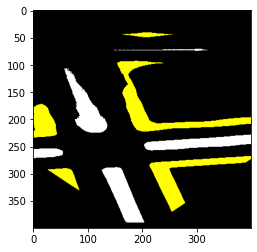

In [310]:
hsv = cv2.cvtColor(img_projected, cv2.COLOR_BGR2HSV)
filter_yellow_img = (filter_yellow(hsv) * 255).astype(np.uint8)
filter_white_img = (filter_white(hsv) * 255).astype(np.uint8)

ret, mask_yellow = cv2.threshold(filter_yellow_img, 40, 255, type=cv2.THRESH_BINARY)
ret, mask_white = cv2.threshold(filter_white_img, 80, 255, type=cv2.THRESH_BINARY)

yellow = np.array((0,1,1), dtype=np.uint8)
white = np.array((1,1,1), dtype=np.uint8)
thresh = mask_yellow[...,None] * yellow + mask_white[...,None] * white
show(thresh)

93 white lines found!
104 yellow lines found!


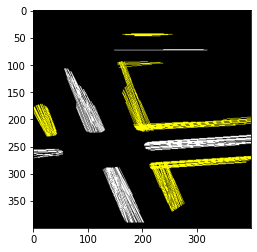

In [322]:
img_w_lines = np.zeros_like(img_projected)

lines_white = cv2.HoughLinesP(mask_white, 1, np.pi/180, 40, minLineLength=40, maxLineGap=10)[:,0]
if lines_white is not None:
    print(f"{len(lines_white)} white lines found!")
    for x1,y1,x2,y2 in lines_white:
        cv2.line(img_w_lines,(x1,y1),(x2,y2),(255,255,255),1)

lines_yellow = cv2.HoughLinesP(mask_yellow, 1, np.pi/180, 40, minLineLength=40, maxLineGap=10)[:,0]
if lines_yellow is not None:
    print(f"{len(lines_yellow)} yellow lines found!")
    for x1,y1,x2,y2 in lines_yellow:
        cv2.line(img_w_lines,(x1,y1),(x2,y2),(0,255,255),1)

show(img_w_lines)

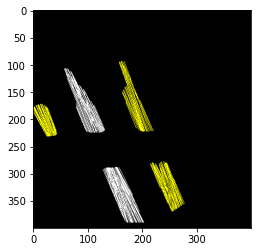

In [326]:
vertices_white = lines_white.reshape(-1,2,2)
vertices_yellow = lines_yellow.reshape(-1,2,2)

absdiff_white = np.abs(vertices_white[:,1] - vertices_white[:,0])
absdiff_yellow = np.abs(vertices_yellow[:,1] - vertices_yellow[:,0])

mask_white_vertical = absdiff_white[:,1] > absdiff_white[:,0]
mask_yellow_vertical = absdiff_yellow[:,1] > absdiff_yellow[:,0]

img_w_lines = np.zeros_like(img_projected)

for x1,y1,x2,y2 in lines_white[mask_white_vertical]:
    cv2.line(img_w_lines,(x1,y1),(x2,y2),(255,255,255),1)

for x1,y1,x2,y2 in lines_yellow[mask_yellow_vertical]:
    cv2.line(img_w_lines,(x1,y1),(x2,y2),(0,255,255),1)

show(img_w_lines)

array([220.5, 371. ])

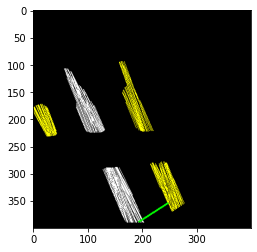

In [366]:
band_height = 20

vertices_white_vertical = vertices_white[mask_white_vertical]
vertices_yellow_vertical = vertices_yellow[mask_yellow_vertical]

left_max_y = np.max(vertices_white_vertical[...,1])
right_max_y = np.max(vertices_yellow_vertical[...,1])

left_min_y = left_max_y - band_height
right_min_y = right_max_y - band_height
left_mask = (vertices_white_vertical[...,1] > left_min_y) & (vertices_white_vertical[...,1] < left_max_y)
right_mask = (vertices_yellow_vertical[...,1] > right_min_y) & (vertices_yellow_vertical[...,1] < right_max_y)

#if not np.any(left_mask) or not np.any(right_mask):
#    return (CENTER, 0)

left_corner_idx = np.argmax(vertices_white_vertical[left_mask,0])
right_corner_idx = np.argmin(vertices_yellow_vertical[right_mask,0])

left_corner = vertices_white_vertical[left_mask][left_corner_idx]
right_corner = vertices_yellow_vertical[right_mask][right_corner_idx]

mid = (left_corner + right_corner) / 2

cv2.line(img_w_lines,left_corner,right_corner,(0,255,0),2)
show(img_w_lines)

mid

In [389]:
# https://stackoverflow.com/a/51240898
# Given a line with coordinates 'start' and 'end' and the
# coordinates of a point 'pnt' the proc returns the shortest 
# distance from pnt to the line and the coordinates of the 
# nearest point on the line.
#
# 1  Convert the line segment to a vector ('line_vec').
# 2  Create a vector connecting start to pnt ('pnt_vec').
# 3  Find the length of the line vector ('line_len').
# 4  Convert line_vec to a unit vector ('line_unitvec').
# 5  Scale pnt_vec by line_len ('pnt_vec_scaled').
# 6  Get the dot product of line_unitvec and pnt_vec_scaled ('t').
# 7  Ensure t is in the range 0 to 1.
# 8  Use t to get the nearest location on the line to the end
#    of vector pnt_vec_scaled ('nearest').
# 9  Calculate the distance from nearest to pnt_vec_scaled.
# 10 Translate nearest back to the start/end line. 
# Malcolm Kesson 16 Dec 2012
# Edited by Amit 21 Nov 2021

def pnt2line(pnt, start, end):
    line_vec = end - start
    pnt_vec = pnt - start
    line_len = np.linalg.norm(line_vec,axis=-1)
    line_unitvec = line_vec / line_len[...,None]
    pnt_vec_scaled = pnt_vec / line_len[...,None]
    t = np.einsum('...i,...i', line_unitvec, pnt_vec_scaled)
    t = np.clip(t, 0.0, 1.0)
    nearest = line_vec * t[...,None]
    dist = np.linalg.norm(nearest - pnt_vec,axis=-1)
    nearest += start
    return (dist, nearest)

In [364]:
pnt = np.array([(5,5),(5,5),(6,6)])
start = np.array([(10,0),(11,0),(11,0)])
end = np.array([(0,20),(1,19),(1,19)])
pnt2line(pnt, start, end)

(array([2.23606798, 2.98077717, 1.63011251]),
 array([[7.        , 6.        ],
        [7.63774403, 6.38828633],
        [7.44251627, 6.75921909]]))

In [365]:
pnt = np.array((5,5))
start = np.array((8,10))
end = np.array((10,20))
print(pnt2line(pnt, start, end))
print(pnt2line(pnt, end, start))

(5.830951894845301, array([ 8., 10.]))
(5.830951894845301, array([ 8., 10.]))


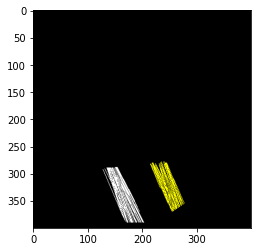

In [368]:
ROAD_WIDTH = 50
dist_left, nearest_left = pnt2line(left_corner, vertices_white_vertical[:,0], vertices_white_vertical[:,1])
dist_right, nearest_right = pnt2line(right_corner, vertices_yellow_vertical[:,0], vertices_yellow_vertical[:,1])

lines_road_left = lines_white[mask_white_vertical][dist_left < ROAD_WIDTH]
lines_road_right = lines_yellow[mask_yellow_vertical][dist_right < ROAD_WIDTH]

roads = np.zeros_like(img_projected)

for x1,y1,x2,y2 in lines_road_left:
    cv2.line(roads,(x1,y1),(x2,y2),(255,255,255),1)

for x1,y1,x2,y2 in lines_road_right:
    cv2.line(roads,(x1,y1),(x2,y2),(0,255,255),1)

show(roads)

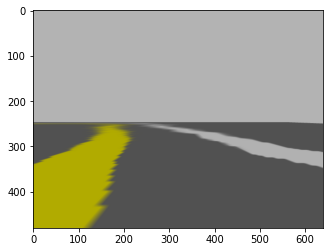

[[[179 179 179]
  [179 179 179]
  [179 179 179]
  ...
  [179 179 179]
  [179 179 179]
  [179 179 179]]

 [[179 179 179]
  [179 179 179]
  [179 179 179]
  ...
  [179 179 179]
  [179 179 179]
  [179 179 179]]

 [[179 179 179]
  [179 179 179]
  [179 179 179]
  ...
  [179 179 179]
  [179 179 179]
  [179 179 179]]

 ...

 [[  0 171 177]
  [  0 171 177]
  [  0 171 177]
  ...
  [ 81  81  81]
  [ 81  81  81]
  [ 81  81  81]]

 [[  0 171 177]
  [  0 171 177]
  [  0 171 177]
  ...
  [ 81  81  81]
  [ 81  81  81]
  [ 81  81  81]]

 [[  0 171 177]
  [  0 171 177]
  [  0 171 177]
  ...
  [ 81  81  81]
  [ 81  81  81]
  [ 81  81  81]]]


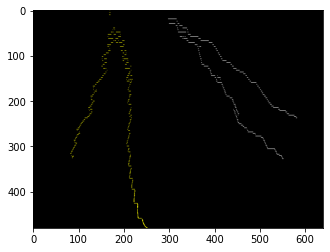

In [ ]:
Y_VANISHING_NEAR = 105
Y_VANISHING_FAR = 225

img = image()
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
filter_yellow_img = (filter_yellow(hsv) * 255).astype(np.uint8)
filter_white_img = (filter_white(hsv) * 255).astype(np.uint8)
filter_white_img[:260,:] = 0 # Erase sky
edges_yellow = cv2.Canny(filter_yellow_img, 20, 240)
edges_white = cv2.Canny(filter_white_img, 20, 240)

right_edges_idx = np.moveaxis(np.indices(edges_white.shape),0,-1)[edges_white>127].reshape(-1,2)
right_edges_xy = perspective_tf(idx_to_xy(right_edges_idx))

left_edges_idx = np.moveaxis(np.indices(edges_yellow.shape),0,-1)[edges_yellow>127].reshape(-1,2)
left_edges_xy = perspective_tf(idx_to_xy(left_edges_idx))

# Draw top-down perspective
img_overhead = np.zeros_like(img)
img_overhead[tuple(xy_to_idx(left_edges_xy).astype(int).clip((0,0),(HEIGHT-1,WIDTH-1)).T)] = (0, 255, 255)
img_overhead[tuple(xy_to_idx(right_edges_xy).astype(int).clip((0,0),(HEIGHT-1,WIDTH-1)).T)] = (255, 255, 255)

show(img)
plt.show()
show(img_overhead)

In [383]:
vertices_road_left = vertices_white_vertical[dist_left < ROAD_WIDTH]
vertices_road_right = vertices_yellow_vertical[dist_right < ROAD_WIDTH]

diff_road_left = vertices_road_left[:,1] - vertices_road_left[:,0]
diff_road_right = vertices_road_right[:,1] - vertices_road_right[:,0]

len_road_left = np.linalg.norm(diff_road_left, axis=-1)
len_road_right = np.linalg.norm(diff_road_right, axis=-1)

theta_left = np.average(np.arctan(diff_road_left[:,1] / diff_road_left[:,0]), weights=len_road_left)
theta_right = np.average(np.arctan(diff_road_right[:,1] / diff_road_right[:,0]), weights=len_road_right)

print(theta_left, theta_right)

theta = np.mean([theta_left, theta_right])
if theta > 0:
    theta = theta - np.pi
theta

1.1613246272632116 1.1927849450924164


-1.964537867411979

In [384]:
len_left = np.mean(len_road_left)
len_right = np.mean(len_road_right)
length = np.mean([len_left, len_right])
length

90.59237964516768

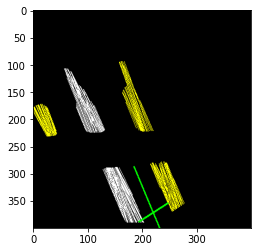

In [385]:
end = mid + length * np.array([np.cos(theta), np.sin(theta)])
cv2.line(img_w_lines,mid.astype(int),end.astype(int),(0,255,0),2)
show(img_w_lines)

In [393]:
def filter_lines(vertices, point, max_dist):
    dist, nearest = pnt2line(point, vertices[...,0,:], vertices[...,1,:])
    return dist < max_dist

In [398]:
from importlib import reload
import follower_p_intersections as fpi
reload(fpi)
shape = (400,400)
fpi.xy_to_phy(np.array([(0,0),(200,400),(250,400),(150,350)]), shape)

array([[-10.   ,   5.   ],
       [  0.   ,  -0.   ],
       [  2.5  ,  -0.   ],
       [ -2.5  ,   0.625]])

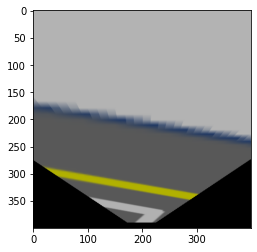

In [402]:
width = 400
height = 400

img = image()
perspective = fpi.PerspectiveShift(K)
img_projected = perspective.warp(img, (width,height))
img_projected = np.ascontiguousarray(img_projected, dtype=np.uint8)
hsv = cv2.cvtColor(img_projected, cv2.COLOR_BGR2HSV)

show(img_projected)

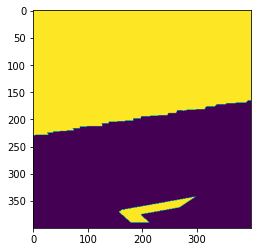

In [409]:
filter_yellow = fpi.Filter(**fpi.YELLOW_FILTER)
filter_white = fpi.Filter(**fpi.WHITE_FILTER)

filter_yellow_img = (filter_yellow.apply(hsv) * 255).astype(np.uint8)
filter_white_img = (filter_white.apply(hsv) * 255).astype(np.uint8)

_, thresh_yellow = cv2.threshold(filter_yellow_img, 40, 255, type=cv2.THRESH_BINARY)
_, thresh_white = cv2.threshold(filter_white_img, 80, 255, type=cv2.THRESH_BINARY)

mask_white = thresh_white > 127

show(mask_white)

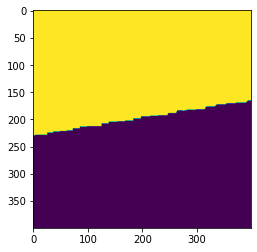

In [453]:
def mask_from_top(mask):
    mask_extended = np.concatenate([mask, np.zeros((1,mask.shape[1]))], axis=0)
    dist = np.argmin(mask_extended, axis=0)
    idx = np.indices(mask.shape)[0]
    return idx < dist

show(mask_from_top(mask_white))

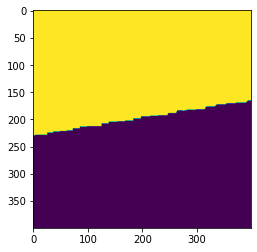

In [456]:
def mask_from_edges(mask):
    mask_top = mask_from_top(mask)
    mask_bot = mask_from_top(mask[::-1])[::-1]

    mask_right = mask_from_top(mask.T).T
    mask_left = mask_from_top(mask[::-1].T).T[::-1]

    return mask_top | mask_bot | mask_right | mask_left

show(mask_from_edges(mask_white))